In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs, plot_numerical_diffs_single

In [2]:
from src.vlstm_fwbw_v2.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v2.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v2.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v2/build.ninja...
Building extension module vlstm_fwbw_v2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /home/max/miniconda3/envs/xlstmpt220cu121/bin/nvcc --generate-dependencies-with-compile --dependency-output kernel_fw.cuda.o.d -ccbin /home/max/miniconda3/envs/xlstmpt220cu121/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=vlstm_fwbw_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERS

Loading extension module vlstm_fwbw_v2...


In [3]:
# non tensor core version:
# ptxas info    : 136 bytes gmem
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 77 registers, 448 bytes cmem[0]
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 77 registers, 448 bytes cmem[0]

# tensor core version:
# ptxas info    : 136 bytes gmem
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 96 registers, 448 bytes cmem[0]
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 94 registers, 448 bytes cmem[0]

## CUDA vLSTM forward-backward 

Choose large tile sizes.

### Get gpu_info

In [4]:
from src.gpu_info.gpu_info import get_gpu_info

In [5]:
# get_gpu_info(0)

### define inputs

In [6]:
S = 64 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 96 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [7]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# qs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# # vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 100.
# # vs = torch.zeros((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# vs[:,:,1,0] = 7.
# qs[:,:,1,0] = 1.

# vs[:,:,1,16] = 8.
# qs[:,:,1,16] = 1.
# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [8]:
# qs[:, :, 16,0] = 1.

In [9]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [10]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [11]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt, matC_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)

In [12]:
hs_pt_half, n_pt_half, m_pt_half, _, matLogD_pt_half, matD_pt_half, matC_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)

In [13]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matLogD_pt_bf16, matD_pt_bf16, matC_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)

In [14]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")

print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")


====== Full -> Half ======
fw hs match: False, max diff: 0.036484718322753906
fw n match: False, max diff: 0.014554262161254883
fw m match: False, max diff: 0.013850808143615723
fw D match: False, max diff: 0.011723697185516357
====== Full -> bfloat16 ======
fw hs match: False, max diff: 0.332843542098999
fw n match: False, max diff: 0.20665717124938965
fw m match: False, max diff: 0.11692214012145996
fw D match: False, max diff: 0.11114472150802612


### match directly

In [15]:
# cuda kernel float32
# hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

In [16]:
hs_cu = hs_pt
n_cu = n_pt
m_cu = m_pt
matD_cu = matD_pt

In [17]:
s_pt_half = (qs_half @ ks_half.transpose(-2, -1)).tril()
s_pt_half.shape

torch.Size([1, 1, 64, 64])

In [18]:
def lower_triangular_block_matrix(n, block_size):
    assert n % block_size == 0
    n_blocks = n // block_size
    
    mat = torch.zeros((n, n), device=DEVICE, dtype=DTYPE)
    for i in range(n_blocks):
        mat[i*block_size:(i+1)*block_size, :(i+1)*block_size] = 1.
    return mat

In [19]:
# compute the baseline for qkv tensor core computation
ltr_bmat = lower_triangular_block_matrix(S, 16)
s_block_pt = (qs @ ks.transpose(-2, -1)) * ltr_bmat
qkv_block_pt = s_block_pt @ vs

In [20]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 64, DH: 96
NUM_WARPS:4, GMEM_LOAD_BLOCK_COLS_X:4, GMEM_LOAD_BLOCK_ROWS_Y:32
blocksxy: 1-2, threadsxy: 128-1, QtileDim: 64, KVtileDim: 64, shared_mem in bytes: 94464
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 128, bdim.y: 1
In FW-Kernel: QtileDim: 64, KVtileDim: 64


In [55]:
hs_cu_half[:,:, :12, :10]

tensor([[[[-5.8105e-01, -1.0215e+00,  8.3301e-01,  3.2397e-01,  4.7656e-01,  7.4561e-01, -5.8252e-01,  1.8506e+00,  2.0398e-01,  2.4182e-01],
          [-7.0820e+00, -2.2781e+01,  3.3945e+00,  1.3906e+00,  9.4062e+00,  1.5250e+01, -1.5488e+00,  3.6812e+01,  8.1094e+00,  1.7656e+00],
          [ 4.9609e+00,  1.8838e+00, -7.1777e-01,  4.6875e+00, -9.1406e+00,  5.1328e+00,  1.2125e+01, -3.3633e+00,  4.1680e+00,  5.7188e+00],
          [ 1.6906e+01, -1.1943e+00, -2.2469e+01,  1.8281e+01, -6.0375e+01, -2.7141e+01, -1.9854e+00, -7.1680e+00, -1.5703e+01, -6.8047e+00],
          [-1.0332e+00,  8.0273e-01,  6.6846e-01, -2.9248e-01,  2.3867e+00,  1.2344e+00, -4.8553e-02, -2.9956e-01,  5.3174e-01,  1.1554e-01],
          [ 1.3766e+01, -1.8838e+00, -7.1523e+00,  6.8438e+00, -2.5422e+01,  5.5566e-01, -8.8086e-01, -1.8838e+00, -6.4805e+00,  3.9160e+00],
          [ 3.3789e+00, -1.0928e+00, -1.0605e+00,  2.0273e+00, -1.4395e+00, -2.5000e+00, -3.0933e-01, -5.6299e-01, -5.8047e+00,  2.1074e+00],
      

In [22]:
hs_pt[:,:, :12, :10]

tensor([[[[-0.5810, -1.0216,  0.8331,  0.3239,  0.4767,  0.7455, -0.5826,  1.8502,  0.2040,  0.2418],
          [-0.2159, -0.6951,  0.1034,  0.0423,  0.2870,  0.4652, -0.0471,  1.1229,  0.2474,  0.0538],
          [ 0.6778,  0.2572, -0.0981,  0.6404, -1.2493,  0.7015,  1.6573, -0.4590,  0.5698,  0.7812],
          [ 1.2388, -0.0876, -1.6460,  1.3397, -4.4233, -1.9886, -0.1455, -0.5251, -1.1512, -0.4990],
          [-1.0328,  0.8024,  0.6679, -0.2921,  2.3852,  1.2342, -0.0485, -0.2994,  0.5317,  0.1156],
          [ 0.4719, -0.0645, -0.2451,  0.2346, -0.8715,  0.0191, -0.0303, -0.0646, -0.2223,  0.1343],
          [ 0.2650, -0.0858, -0.0831,  0.1591, -0.1127, -0.1960, -0.0243, -0.0441, -0.4555,  0.1655],
          [ 0.0231,  0.1692, -0.1722,  0.1120, -0.1220, -0.0145, -0.0189, -0.1762,  0.2332, -0.2244],
          [ 2.4977,  0.7492,  1.6552,  0.2716, -0.2086, -1.2906,  0.2887, -1.0673,  0.3586,  0.3178],
          [-0.0166, -0.3472,  0.7615, -0.4569,  0.2895,  0.4645,  0.4374,  0.8803,

tensor(61.7895, device='cuda:0')

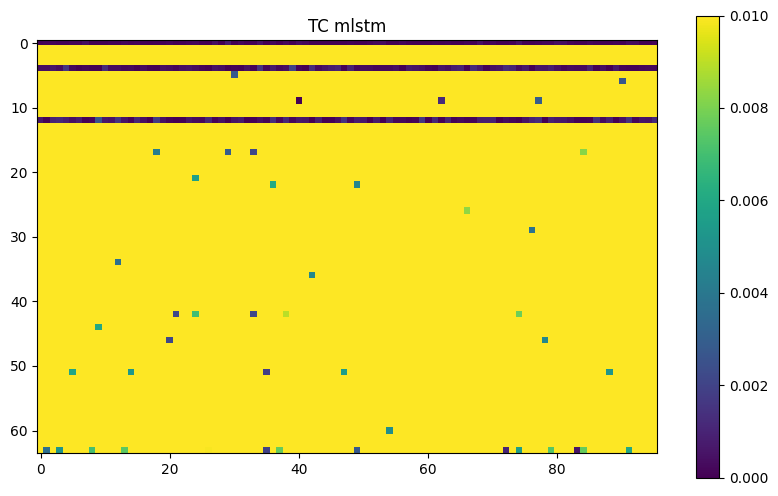

In [54]:
fig = plot_numerical_diffs_single(hs_cu_half, hs_pt, title="TC mlstm", vmax=0.01)
(hs_cu_half - hs_pt).abs().max()

In [24]:
t1 = torch.tensor([8.3190], dtype=torch.float32, device=DEVICE)
print(t1)
print(t1.half())

tensor([8.3190], device='cuda:0')
tensor([8.3203], device='cuda:0', dtype=torch.float16)


In [25]:
qkv_block_pt[:, :, -10:, :15]

tensor([[[[ -13.9585,  -72.0976,  -96.1890,   99.7617,  -78.3086,  -11.3578,  -36.6435,  -95.3184,  -44.6306,   -5.4199,  -12.7401,   15.8346,   62.3398,   -4.8841,  -10.8061],
          [ -21.0055,  -23.9881, -132.5443,  104.9668,  -60.3126,   47.6450,   50.0287,  -91.5766, -175.3194,    5.3197,  -20.7851,   76.6715,   20.5771,  -41.2961, -133.8271],
          [ -22.1365,    7.4471,  253.3180, -121.0750,  140.2586,  -10.9459,   53.4929,   -4.6931, -137.6882,   32.2942,  -82.0566,  107.9092,  -45.7919,  -61.7244,   51.4104],
          [  42.8880, -110.5839,  -11.8239,  -28.9694,  186.2809,    0.3414,   55.3051,  171.9915,  142.3602, -125.9160,  -86.3929,  -88.6987,  218.0894,  -36.0682,  -21.8823],
          [ -12.2560,   21.8175,    4.4152,  -19.3280,   66.0096,   25.8900,   75.4686,  -35.3098,  -25.9519,   18.6759,  -43.6493,   22.3426,  -30.9991,  -10.8207,  -36.6493],
          [  -1.6326,   96.1086,   19.7435,  -87.0381,  140.3688,   21.6698,   56.9091,   33.5548,  -47.3626,   18.

In [26]:
hs_cu_half[:, :, -10:, :15]

tensor([[[[-1.9984e+01, -5.2852e+00, -2.0500e+01,  7.5938e+00, -1.5439e+00,  1.0336e+01,  6.4688e+00,  1.5219e+01,  9.6484e+00, -1.7188e+01, -1.6578e+01, -1.9172e+01, -3.8361e-02,  2.3418e+00,
           -2.6387e+00],
          [-2.0656e+01, -4.5281e+01, -3.3625e+01, -2.7891e+00, -1.2875e+01,  9.8984e+00, -1.6688e+01, -6.9102e+00, -8.1641e+00, -7.3633e-01, -2.8688e+01,  8.2568e-01, -1.0742e+01,  2.7250e+01,
           -8.6328e+00],
          [ 1.1453e+01,  2.7453e+01, -2.0293e+00, -7.6641e+00, -1.6703e+01, -5.9688e+00,  1.6359e+01,  6.0508e+00,  8.6094e+00,  1.0070e+01,  1.8234e+01, -7.3008e+00,  2.6422e+01, -2.3469e+01,
           -5.0820e+00],
          [-6.2266e+00,  7.1719e+00, -3.4562e+01, -1.5828e+01, -1.5867e+01, -7.8750e+00,  3.4094e+01,  9.7969e+00, -1.0820e+00,  1.0508e+01, -1.0303e+00, -2.6156e+01,  2.9422e+01, -2.1094e+01,
            1.6688e+01],
          [ 9.0186e-01,  3.2148e+00,  1.4039e+01, -8.5469e+00,  1.2094e+01, -7.2773e+00,  5.8350e-01,  7.7227e+00, -4.0586e+00, 

tensor(292.4969, device='cuda:0')

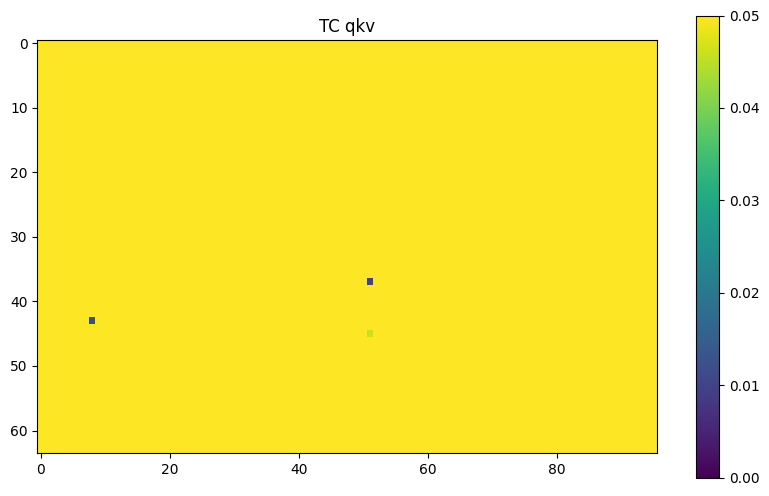

In [27]:
fig = plot_numerical_diffs_single(hs_cu_half, qkv_block_pt, title="TC qkv", vmax=0.05)
(hs_cu_half - qkv_block_pt).abs().max()

In [28]:
s_pt_half[:, :, :16, :12]

tensor([[[[  9.9297,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ 13.2578,   6.8711,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -7.4570,   7.9727,   7.3398,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -1.7695,  -0.8560,   7.5391, -16.5312,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -3.5684,  -7.4180,  -4.7344,  10.8594,  11.2266,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -2.1602,  17.6250,   8.1250, -10.1875,  -5.4180,  -4.2812,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  2.7363,   2.5859,  -1.9131, -10.7344,  -0.1101,  -0.8018,  -1.9932,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ 23.3594,  -9.7891,   4.2969, -16.5625,  -3.8125,  -8.0938,   2.2

In [29]:
matD_cu_half[:, :, :16, 0:12]

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]], device='cuda:0', dtype=torch.float16)

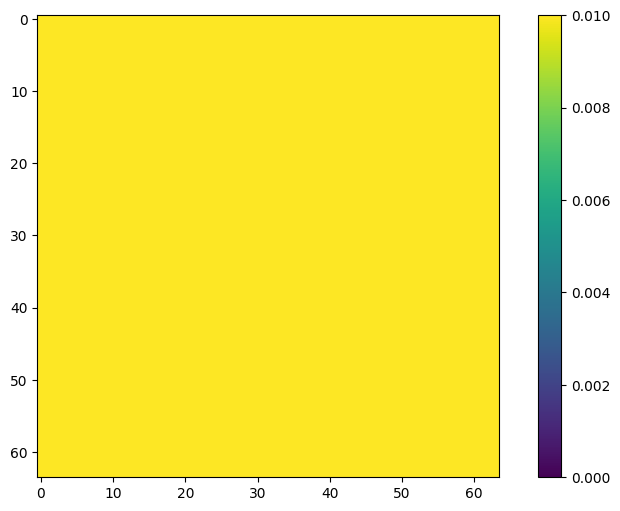

In [30]:
fig = plot_numerical_diffs_single(s_pt_half, matD_cu_half)

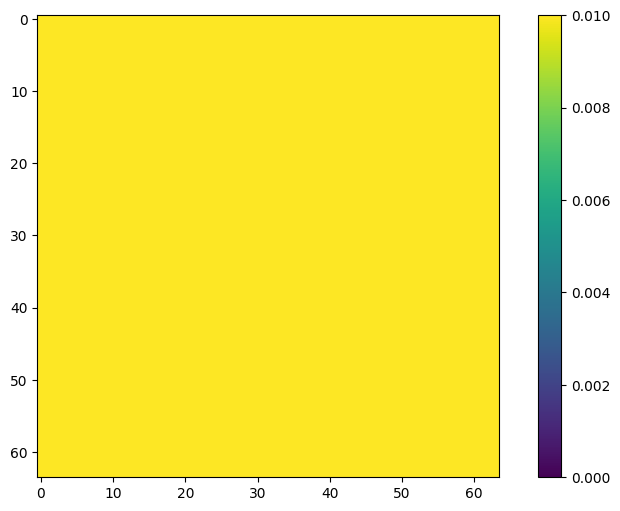

In [31]:
fig = plot_numerical_diffs_single(matD_cu_half)

In [32]:
matLogD_pt[:, :, -10:, :10]

tensor([[[[-47.9411, -48.0294, -45.9642, -45.0512, -45.2739, -44.5872, -42.2067, -41.2310, -41.8071, -38.8284],
          [-48.6404, -48.7287, -46.6635, -45.7505, -45.9732, -45.2865, -42.9059, -41.9303, -42.5063, -39.5277],
          [-49.2012, -49.2895, -47.2243, -46.3113, -46.5341, -45.8473, -43.4668, -42.4911, -43.0672, -40.0885],
          [-49.3767, -49.4650, -47.3998, -46.4868, -46.7095, -46.0228, -43.6422, -42.6666, -43.2426, -40.2640],
          [-51.0452, -51.1335, -49.0683, -48.1553, -48.3780, -47.6913, -45.3107, -44.3351, -44.9111, -41.9325],
          [-52.9419, -53.0302, -50.9650, -50.0520, -50.2747, -49.5880, -47.2074, -46.2318, -46.8078, -43.8292],
          [-53.1827, -53.2710, -51.2058, -50.2928, -50.5155, -49.8288, -47.4482, -46.4726, -47.0487, -44.0700],
          [-53.8156, -53.9039, -51.8387, -50.9257, -51.1485, -50.4617, -48.0812, -47.1055, -47.6816, -44.7029],
          [-54.9351, -55.0234, -52.9582, -52.0452, -52.2679, -51.5812, -49.2006, -48.2250, -48.8011, -45

In [33]:
matD_cu_half[:, :, -10:, :10]

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]], device='cuda:0', dtype=torch.float16)

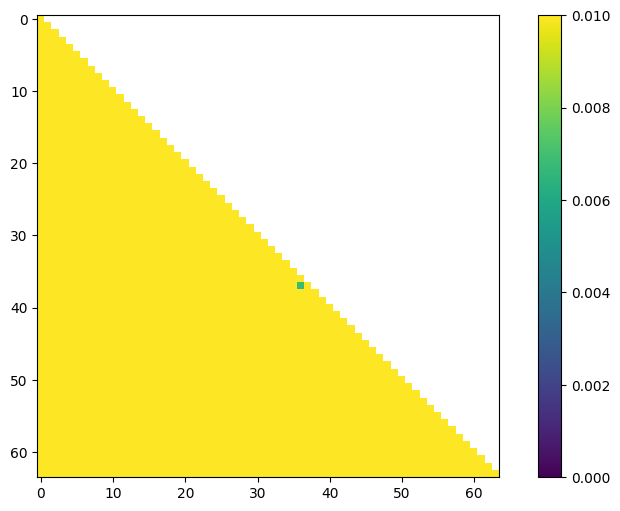

In [34]:
fig = plot_numerical_diffs_single(matLogD_pt, matD_cu_half)

In [35]:
(s_pt_half - matD_cu_half)[:, : , :10, :10]

tensor([[[[  8.9297,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
          [ 12.2578,   5.8711,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
          [ -8.4531,   6.9727,   6.3398,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
          [ -2.7695,  -1.8555,   6.5391, -17.5312,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
          [ -4.5703,  -8.4219,  -5.7344,   9.8594,  10.2266,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
          [ -3.1602,  16.6250,   7.1250, -11.1875,  -6.4180,  -5.2812,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
          [  1.7363,   1.5859,  -2.9141, -11.7344,  -1.1104,  -1.8018,  -2.9922,  -1.0000,  -1.0000,  -1.0000],
          [ 22.3594, -10.7891,   3.2969, -17.5625,  -4.8125,  -9.0938,   1.2969,  -0.3926,  -1.0000,  -1.0000],
          [  0.1357, -13.4688,   7.1328,  -0.7695,   4.8672, -11.6719,  -0.5068,   3.8320, -17.7500,  -1

In [36]:
(s_pt_half - matD_cu_half).abs().max()

tensor(44.9688, device='cuda:0', dtype=torch.float16)

In [37]:
vs_half[:, :, :3, 32:]

tensor([[[[ 8.4326e-01,  2.5024e-01,  1.9668e+00, -7.2607e-01, -1.2266e+00,  1.9922e-01, -1.4668e+00, -6.7188e-01, -1.1328e+00,  1.1963e+00, -2.1912e-02, -2.8015e-02, -1.1530e-01,  1.5240e-03,
            7.8857e-01,  2.9565e-01,  1.1113e+00,  9.4580e-01, -7.9980e-01,  7.6221e-01,  1.0244e+00, -1.7090e+00, -3.4009e-01, -3.1274e-01,  1.3672e+00, -7.6123e-01, -1.8396e-01, -7.4707e-01,
            6.4697e-02,  1.2637e+00,  4.2139e-01,  2.8687e-01,  2.6538e-01,  3.9307e-02,  6.1377e-01,  1.6553e+00,  1.6846e+00, -4.0112e-01, -1.2900e+00, -3.8672e-01,  2.7295e-01,  3.5864e-01,
            1.6729e+00, -2.2949e-01,  2.2217e-01,  4.6655e-01, -5.3223e-01, -7.4463e-01, -1.1768e+00, -1.0029e+00, -1.7520e+00, -8.1201e-01, -1.5161e-01,  7.7979e-01,  6.8604e-01, -1.5332e-01,
           -9.6558e-02,  5.5078e-01,  7.2314e-01, -1.8262e+00, -1.0332e+00, -1.0590e-01,  5.8740e-01, -9.9414e-01],
          [ 8.2031e-01,  2.0879e+00,  4.3188e-01,  4.7180e-02,  1.0889e+00,  2.4524e-01,  1.7053e-01, -1.2090e+0

In [38]:
matD_cu_half.shape

torch.Size([1, 1, 64, 64])

In [39]:
matD_cu_half[:, :, :10, :10]

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]], device='cuda:0', dtype=torch.float16)

In [40]:
hs_cu_half[:, :, :3, 32:]

tensor([[[[ 8.4326e-01,  2.5024e-01,  1.9668e+00, -7.2607e-01, -1.2266e+00,  1.9922e-01, -1.4668e+00, -6.7188e-01, -1.1328e+00,  1.1963e+00, -2.1912e-02, -2.8015e-02, -1.1530e-01,  1.5240e-03,
            7.8857e-01,  2.9565e-01,  1.1113e+00,  9.4580e-01, -7.9980e-01,  7.6221e-01,  1.0244e+00, -1.7090e+00, -3.4009e-01, -3.1274e-01,  1.3672e+00, -7.6123e-01, -1.8396e-01, -7.4707e-01,
            6.4697e-02,  1.2637e+00,  4.2139e-01,  2.8687e-01,  2.6538e-01,  3.9307e-02,  6.1377e-01,  1.6553e+00,  1.6846e+00, -4.0112e-01, -1.2900e+00, -3.8672e-01,  2.7295e-01,  3.5864e-01,
            1.6729e+00, -2.2949e-01,  2.2217e-01,  4.6655e-01, -5.3223e-01, -7.4463e-01, -1.1768e+00, -1.0029e+00, -1.7520e+00, -8.1201e-01, -1.5161e-01,  7.7979e-01,  6.8604e-01, -1.5332e-01,
           -9.6558e-02,  5.5078e-01,  7.2314e-01, -1.8262e+00, -1.0332e+00, -1.0590e-01,  5.8740e-01, -9.9414e-01],
          [ 1.6328e+01,  1.6438e+01,  2.8781e+01, -9.3281e+00, -9.4219e+00,  4.1797e+00, -1.8375e+01, -1.6500e+0

In [41]:
(vs_half-hs_cu_half)[:, :, :3, 32:]

tensor([[[[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
             0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
             0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
             0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [-15.5078, -14.3516, -28.3438,   9.3750,  10.5078,  -3.9336,  18.5469,  15.2891,   2.8984, -17.8594,   6.6016,   4.0156,   8.2422,   3.1328,  -1.3984,  -2.4062, -13.6406, -14.0625,  17.3906,
           -11.5781, -14.0938,  17.1562,   0.4524,  -1.5684, -10.0938,  14.8203,  -2.7656,   8.5000,   4.6445,  -9

In [42]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 64, DH: 96
NUM_WARPS:4, GMEM_LOAD_BLOCK_COLS_X:4, GMEM_LOAD_BLOCK_ROWS_Y:32
blocksxy: 1-2, threadsxy: 128-1, QtileDim: 64, KVtileDim: 64, shared_mem in bytes: 94464
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 128, bdim.y: 1
In FW-Kernel: QtileDim: 64, KVtileDim: 64


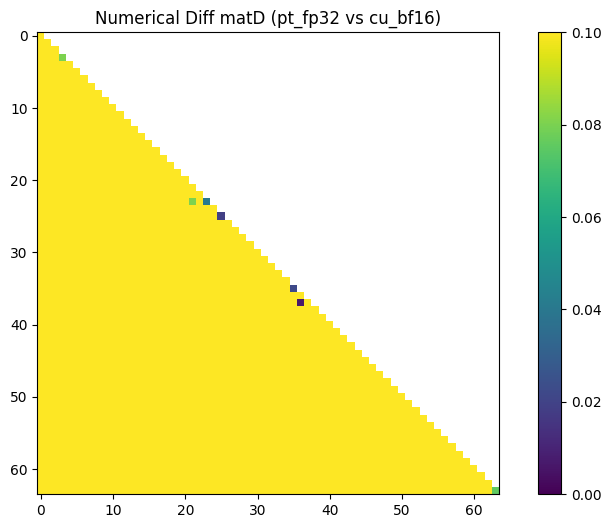

In [43]:
fig = plot_numerical_diffs_single(matLogD_pt, matD_cu_bf16, title="Numerical Diff matD (pt_fp32 vs cu_bf16)", vmax=10e-2)

In [44]:
matD_cu_bf16[:, :, :17, :16]

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1

In [45]:
# (qs_bf16 @ ks_bf16)[:, :, :17, :16]

In [46]:
hs_cu_half.shape, qs_half.shape

(torch.Size([1, 1, 64, 96]), torch.Size([1, 1, 64, 96]))

In [47]:
hs_cu_half, qs

(tensor([[[[-5.8105e-01, -1.0215e+00,  8.3301e-01,  3.2397e-01,  4.7656e-01,  7.4561e-01, -5.8252e-01,  1.8506e+00,  2.0398e-01,  2.4182e-01,  4.8901e-01, -8.7939e-01,  6.0400e-01, -5.7324e-01,
            -1.2197e+00, -1.8516e+00,  8.5498e-01,  2.4487e-01, -1.4746e-01,  1.4453e+00, -8.5254e-01,  9.3555e-01, -9.9316e-01, -6.8604e-01, -6.5039e-01,  5.6445e-01,  6.1279e-01,  1.9902e+00,
            -6.5674e-02, -2.1387e+00, -1.3306e-01, -6.9287e-01,  8.4326e-01,  2.5024e-01,  1.9668e+00, -7.2607e-01, -1.2266e+00,  1.9922e-01, -1.4668e+00, -6.7188e-01, -1.1328e+00,  1.1963e+00,
            -2.1912e-02, -2.8015e-02, -1.1530e-01,  1.5240e-03,  7.8857e-01,  2.9565e-01,  1.1113e+00,  9.4580e-01, -7.9980e-01,  7.6221e-01,  1.0244e+00, -1.7090e+00, -3.4009e-01, -3.1274e-01,
             1.3672e+00, -7.6123e-01, -1.8396e-01, -7.4707e-01,  6.4697e-02,  1.2637e+00,  4.2139e-01,  2.8687e-01,  2.6538e-01,  3.9307e-02,  6.1377e-01,  1.6553e+00,  1.6846e+00, -4.0112e-01,
            -1.2900e+00, -3.86

In [48]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")

print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matLogD_pt).tril())}")

print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matLogD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 0.0
fw n match: True, max diff: 0.0
fw m match: True, max diff: 0.0
fw D match: False, max diff: 43428614144.0
====== Half ======
fw hs match: False, max diff: 61.78947830200195
fw n match: False, max diff: 22.80040740966797
fw m match: False, max diff: 0.0012853145599365234
fw D match: False, max diff: 56.879150390625
====== bfloat16 ======
fw hs match: False, max diff: 61.72697830200195
fw n match: False, max diff: 22.78478240966797
fw m match: False, max diff: 0.005978703498840332
fw D match: False, max diff: 56.879150390625


In [49]:
16 / 4

4.0

In [50]:
13 % 4, 14 % 4

(1, 2)

In [51]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

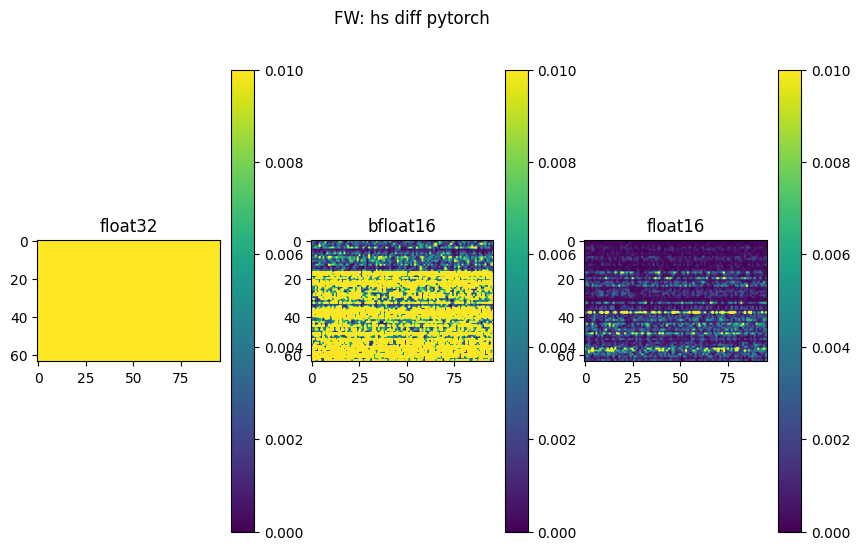

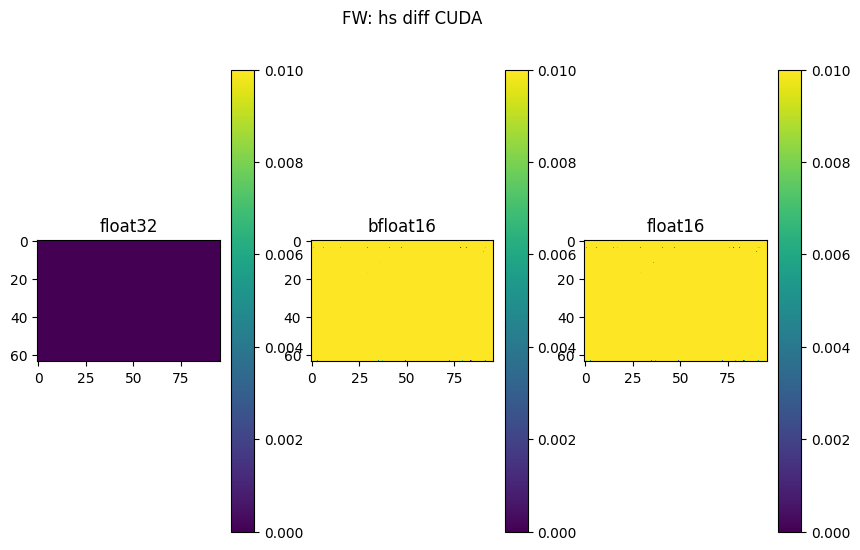

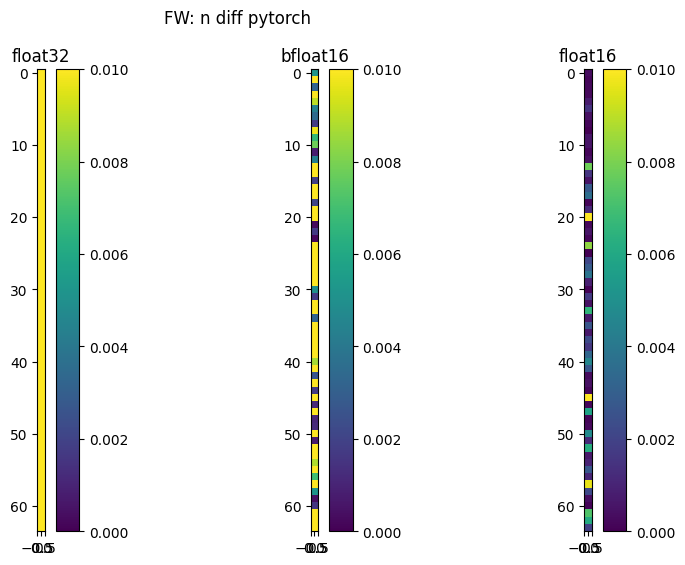

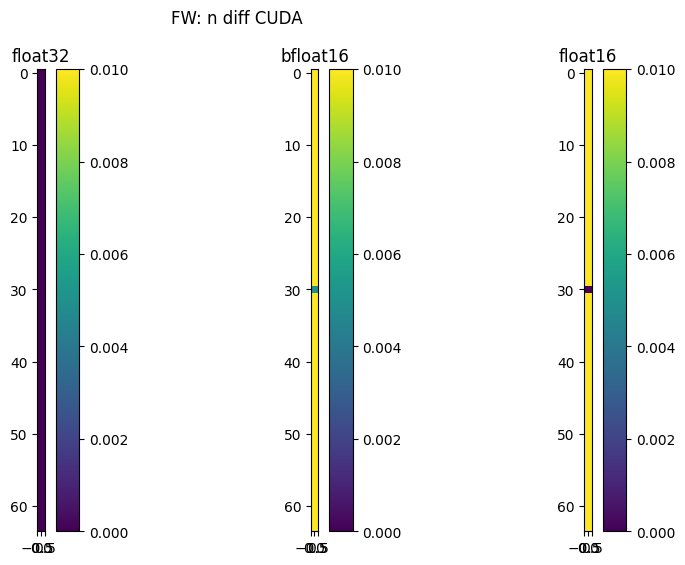

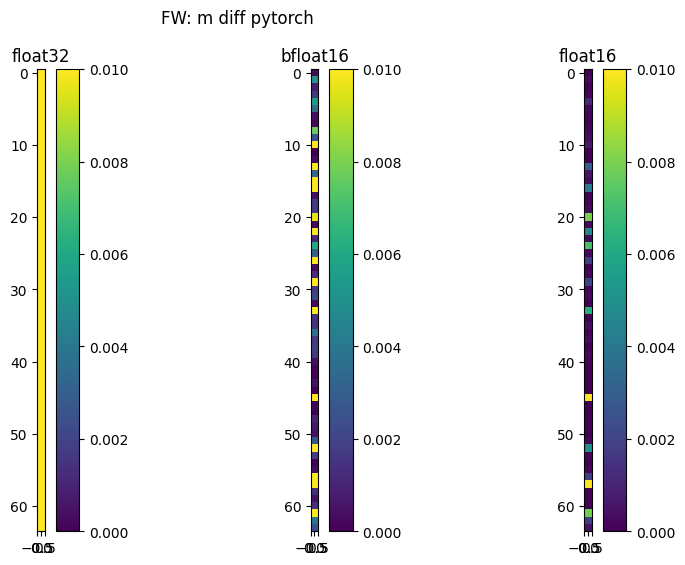

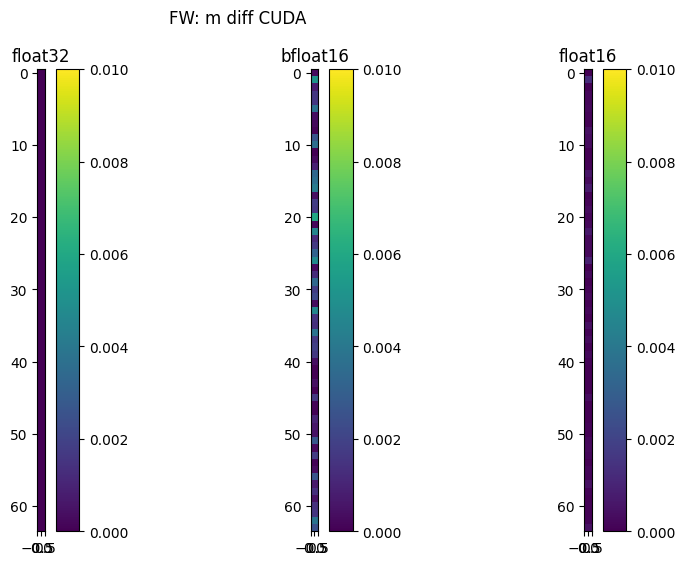

In [52]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")